# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

# Load Data and Data Cleaning

In [2]:
df = pd.read_csv('..\datasets\cleaned_df_2.csv').drop(columns='Unnamed: 0')

C:\Users\hammi\AppData\Local\Temp\ipykernel_1608\2244319844.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('..\datasets\cleaned_df_2.csv').drop(columns='Unnamed: 0')


In [3]:
df.head()

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,affiliation,sec_sch_latitude,sec_sch_longitude,block_type,Tranc_YearMonth_ord,Tranc_Year_ord,Tranc_Month_ord,lease_commence_date_ord,year_completed_ord,area_cost
0,88471,2016-05-01,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006-01-01,...,0,1.317659,103.882504,mixed,736085,735964,693716,732312,731947,very expensive
1,122598,2012-07-01,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987-01-01,...,0,1.350110,103.854892,mixed,734685,734503,693777,725372,725372,very expensive
2,170897,2013-07-01,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997-01-01,...,0,1.342334,103.760013,mixed,735050,734869,693777,729025,728659,expensive
3,86070,2012-04-01,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992-01-01,...,1,1.354789,103.844934,mixed,734594,734503,693686,727198,726468,very expensive
4,153632,2017-12-01,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987-01-01,...,0,1.414888,103.838335,mixed,736664,736330,693930,725372,725372,cheap


The data has been clean in the EDA in 03_EDA_Part_2

# Model Prep: Creating features matrix and target vector

## Preprocessing

Our models will include the following features

`area_cost`

`flat_type_1 ROOM`

`flat_type_1 ROOM` * (`Tranc_YearMonth`), 

`flat_type_2 ROOM`

`flat_type_2 ROOM` * (`flat_model_DBSS`)

`flat_type_3 ROOM` (Which we will drop to avoid collinearity)

`flat_type_3 ROOM` * (`flat_model_DBSS`, `flat_model_Premium Apartment`, `flat_model_Terrace`)

`flat_type_4 ROOM`

`flat_type_4 ROOM` * (`Hawker_Within_2km`, `flat_model_Model A2`, `flat_model_Simplified`, `flat_model_Adjoined flat`, `flat_model_DBSS`, `flat_model_Terrace`,`flat_model_Premium Apartment Loft`, `flat_model_Type S1`)

`flat_type_5 ROOM`

`flat_type_5 ROOM` * (`Hawker_Within_2km`, `flat_model_Type S2`, `flat_model_Premium Apartment Loft`, `flat_model_DBSS`, `flat_model_Improved-Maisonette`, `flat_model_Standard`, `flat_model_Adjoined flat`)

`flat_type_EXECUTIVE`

`flat_type_EXECUTIVE` * (`Hawker_Within_2km`, `flat_model_Premium Maisonette`, `flat_model_Adjoined flat`)

`flat_type_MULTI-GENERATION`

Flat types will be relative to 3 ROOM flats that are not DBSS, Premium or Terrace houses.
Planning Area will be relative to afforable areas.

In [4]:
X=df[['flat_type','planning_area']]
X=pd.get_dummies(columns=['flat_type','planning_area'],data=X)

In [5]:
flat_dummies = pd.get_dummies(columns=['flat_type','flat_model'], data=df)

In [6]:
interaction_terms_list = [('flat_type_1 ROOM','Tranc_YearMonth_ord'), 
                          ('flat_type_2 ROOM','flat_model_DBSS'),
                          ('flat_type_3 ROOM','flat_model_DBSS'),
                          ('flat_type_3 ROOM','flat_model_Premium Apartment'),
                          ('flat_type_3 ROOM','flat_model_Terrace'),
                          ('flat_type_4 ROOM','Hawker_Within_2km'),
                          ('flat_type_4 ROOM','flat_model_Model A2'),
                          ('flat_type_4 ROOM','flat_model_Simplified'),
                          ('flat_type_4 ROOM','flat_model_Adjoined flat'),
                          ('flat_type_4 ROOM','flat_model_DBSS'),
                          ('flat_type_4 ROOM','flat_model_Terrace'),
                          ('flat_type_4 ROOM','flat_model_Premium Apartment Loft'),
                          ('flat_type_4 ROOM','flat_model_Type S1'),
                          ('flat_type_5 ROOM','Hawker_Within_2km'),
                          ('flat_type_5 ROOM','flat_model_Type S2'),
                          ('flat_type_5 ROOM','flat_model_Premium Apartment Loft'),
                          ('flat_type_5 ROOM','flat_model_DBSS'),
                          ('flat_type_5 ROOM','flat_model_Improved-Maisonette'),
                          ('flat_type_5 ROOM','flat_model_Standard'),
                          ('flat_type_5 ROOM','flat_model_Adjoined flat'),
                          ('flat_type_EXECUTIVE','Hawker_Within_2km'),
                          ('flat_type_EXECUTIVE','flat_model_Premium Maisonette'),
                          ('flat_type_EXECUTIVE','flat_model_Adjoined flat')]

In [7]:
for terms in interaction_terms_list:
    X[f"{terms[0]}*{terms[1]}"]= flat_dummies[terms[0]]*flat_dummies[terms[1]]

In [8]:
#dropping the 3 ROOM
X=X.drop(columns=['flat_type_1 ROOM','planning_area_Bukit Merah'])

In [9]:
#create a function to reproduce when generating predictions
def prep_data(df):
    X=df[['flat_type','planning_area']]
    X=pd.get_dummies(columns=['flat_type','planning_area'],data=X)
    flat_dummies = pd.get_dummies(columns=['flat_type','flat_model'], data=df)
    interaction_terms_list = [('flat_type_1 ROOM','Tranc_YearMonth_ord'), 
                          ('flat_type_2 ROOM','flat_model_DBSS'),
                          ('flat_type_3 ROOM','flat_model_DBSS'),
                          ('flat_type_3 ROOM','flat_model_Premium Apartment'),
                          ('flat_type_3 ROOM','flat_model_Terrace'),
                          ('flat_type_4 ROOM','Hawker_Within_2km'),
                          ('flat_type_4 ROOM','flat_model_Model A2'),
                          ('flat_type_4 ROOM','flat_model_Simplified'),
                          ('flat_type_4 ROOM','flat_model_Adjoined flat'),
                          ('flat_type_4 ROOM','flat_model_DBSS'),
                          ('flat_type_4 ROOM','flat_model_Terrace'),
                          ('flat_type_4 ROOM','flat_model_Premium Apartment Loft'),
                          ('flat_type_4 ROOM','flat_model_Type S1'),
                          ('flat_type_5 ROOM','Hawker_Within_2km'),
                          ('flat_type_5 ROOM','flat_model_Type S2'),
                          ('flat_type_5 ROOM','flat_model_Premium Apartment Loft'),
                          ('flat_type_5 ROOM','flat_model_DBSS'),
                          ('flat_type_5 ROOM','flat_model_Improved-Maisonette'),
                          ('flat_type_5 ROOM','flat_model_Standard'),
                          ('flat_type_5 ROOM','flat_model_Adjoined flat'),
                          ('flat_type_EXECUTIVE','Hawker_Within_2km'),
                          ('flat_type_EXECUTIVE','flat_model_Premium Maisonette'),
                          ('flat_type_EXECUTIVE','flat_model_Adjoined flat')]
    for terms in interaction_terms_list:
        X[f"{terms[0]}*{terms[1]}"]= flat_dummies[terms[0]]*flat_dummies[terms[1]]
    X=X.drop(columns=['flat_type_1 ROOM','planning_area_Bukit Merah'])
    return X

Note that the coefficients of the model will be relative to 1 room flats in Bukit Merah.

The choice of 1 ROOM and Bukit Merah is for intepretation purposes.

In [10]:
X.head()

,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,planning_area_Ang Mo Kio,planning_area_Bedok,planning_area_Bishan,planning_area_Bukit Batok,...,flat_type_5 ROOM*Hawker_Within_2km,flat_type_5 ROOM*flat_model_Type S2,flat_type_5 ROOM*flat_model_Premium Apartment Loft,flat_type_5 ROOM*flat_model_DBSS,flat_type_5 ROOM*flat_model_Improved-Maisonette,flat_type_5 ROOM*flat_model_Standard,flat_type_5 ROOM*flat_model_Adjoined flat,flat_type_EXECUTIVE*Hawker_Within_2km,flat_type_EXECUTIVE*flat_model_Premium Maisonette,flat_type_EXECUTIVE*flat_model_Adjoined flat
0,0,0,1,0,0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0,0
1,0,0,0,1,0,0,0,0,1,0,...,7.0,0,0,0,0,0,0,0.0,0,0
2,0,0,0,0,1,0,0,0,0,1,...,0.0,0,0,0,0,0,0,1.0,0,0
3,0,0,1,0,0,0,0,0,1,0,...,0.0,0,0,0,0,0,0,0.0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0,0


In [11]:
y = df['resale_price']*100_000

# Model Prep: Train/Test split

Since our training set is large, we will use 0.8 of the data as our training size.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size=.8)

We will use the same random_state to make both models comparable.

We will also standardize `floor_area_sqm` for lasso and ridge in X_1.

In [13]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

# Instantiate models

In [14]:
lr = LinearRegression()

In [15]:
optimal_lasso = LassoCV(n_alphas = 500,max_iter=2000)

optimal_lasso.fit(X_train,y_train);

In [16]:
optimal_ridge = RidgeCV(alphas = np.linspace(.1, 10, 100))

optimal_ridge.fit(X_train,y_train);

In [17]:
null_model = np.full(shape=len(y), fill_value=y.mean())

Our null model will be the mean resale price.

# X Cross Validation

We'll use RMSE (i.e. closer to 0, better fit)

In [18]:
# Null model
np.sqrt(mean_squared_error(y,null_model))

143212.05306422437

In [19]:
lr_scores_rmse = -cross_val_score(lr,X_train,y_train, scoring = 'neg_root_mean_squared_error')
lr_scores_rmse.mean()

67290.93226537634

In [20]:
lasso_scores_rmse = -cross_val_score(optimal_lasso,X_train,y_train, scoring = 'neg_root_mean_squared_error')
lasso_scores_rmse.mean()

67312.174432113

In [21]:
ridge_scores_rmse = -cross_val_score(optimal_ridge,X_train,y_train, scoring = 'neg_root_mean_squared_error')
ridge_scores_rmse.mean()

67292.62734139951

In [22]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_train,y_train)

Lasso(alpha=72.47497050211322)

In [23]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge.fit(X_train,y_train)

Ridge(alpha=0.1)

In [24]:
lasso_train_rmse = -cross_val_score(lasso,X_train,y_train, scoring = 'neg_root_mean_squared_error')
lasso_test_rmse = -cross_val_score(lasso,X_test,y_test, scoring = 'neg_root_mean_squared_error')

print(f'Train RMSE = {lasso_train_rmse.mean()}, Test RMSE = {lasso_test_rmse.mean()}')

Train RMSE = 67312.15765610246, Test RMSE = 67422.36772509785


In [25]:
ridge_train_rmse = -cross_val_score(ridge,X_train,y_train, scoring = 'neg_root_mean_squared_error')
ridge_test_rmse = -cross_val_score(ridge,X_test,y_test, scoring = 'neg_root_mean_squared_error')

print(f'Train RMSE = {ridge_train_rmse.mean()}, Test RMSE = {ridge_test_rmse.mean()}')

Train RMSE = 67292.6273257622, Test RMSE = 67399.27128508345


In [26]:
lr_train_rmse = -cross_val_score(lr,X_train,y_train, scoring = 'neg_root_mean_squared_error')
lr_test_rmse = -cross_val_score(lr,X_test,y_test, scoring = 'neg_root_mean_squared_error')

print(f'Train RMSE = {lr_train_rmse.mean()}, Test RMSE = {lr_test_rmse.mean()}')

Train RMSE = 67290.93226537634, Test RMSE = 67398.76810008616


Let's compare these with the first two models.

The train/test RSMEs are correct to 3 significant figures.

|RSME train/test|Linear Regression|Lasso|Ridge|
|:--|---|---|---|
|Model 1 (floor area, planning area, block type)|80,500/80,300|80,500/80,300|80,500/80,300|
|Model 2 (full flat type, planning area, block type)|65,500/65,200|65,800/65,600|65,500/65,200|
|Model 3 (area cost, flat type with interactions with flat model)|67,300/67,400|67,300/67,400|67,300/67,400|

Although Model 3 has higher RSME, we can foresee that the interactions providing greater explanatory value since the fit is about the same as Model 2.

Also, we will use linear regression for our Kaggle submission.

# X coef distribution

In [27]:
lr.fit(X_train,y_train)

LinearRegression()

In [28]:
lr.intercept_

448838.88163954904

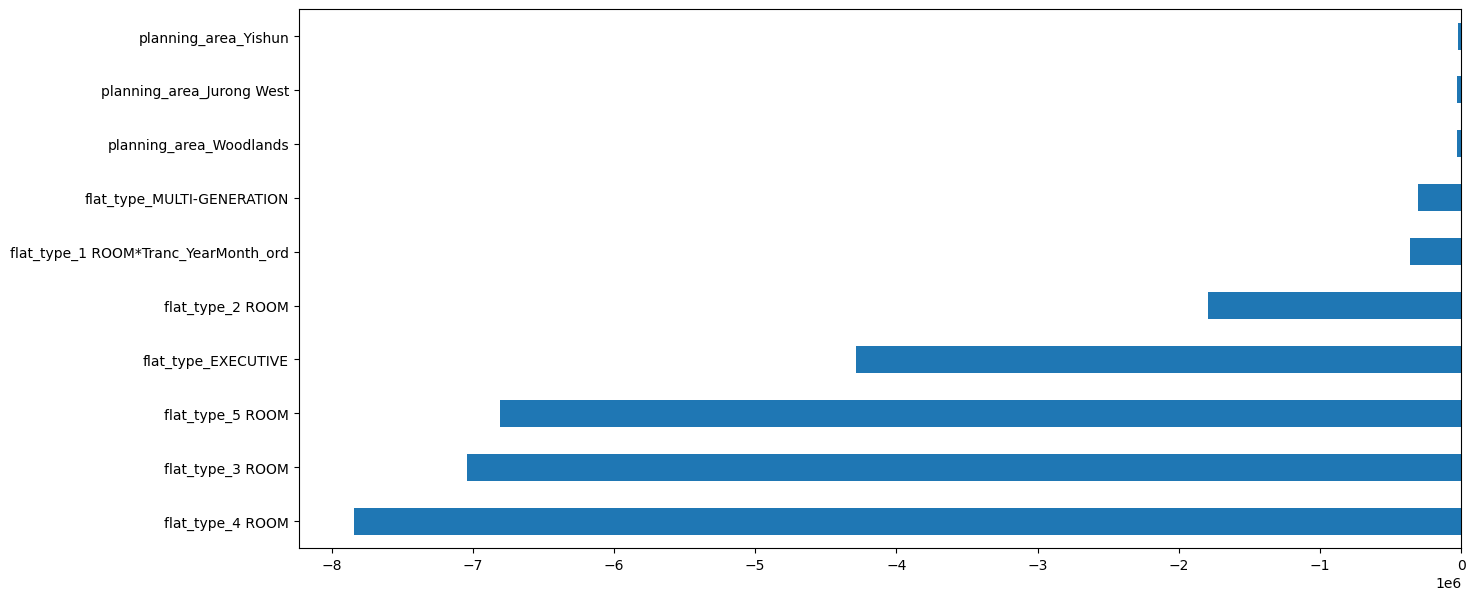

In [29]:
(pd.Series(lr.coef_, index = X.columns)
 .sort_values(ascending=True)[:10]
 .plot(kind = 'barh', figsize=(15,7)))
plt.show()

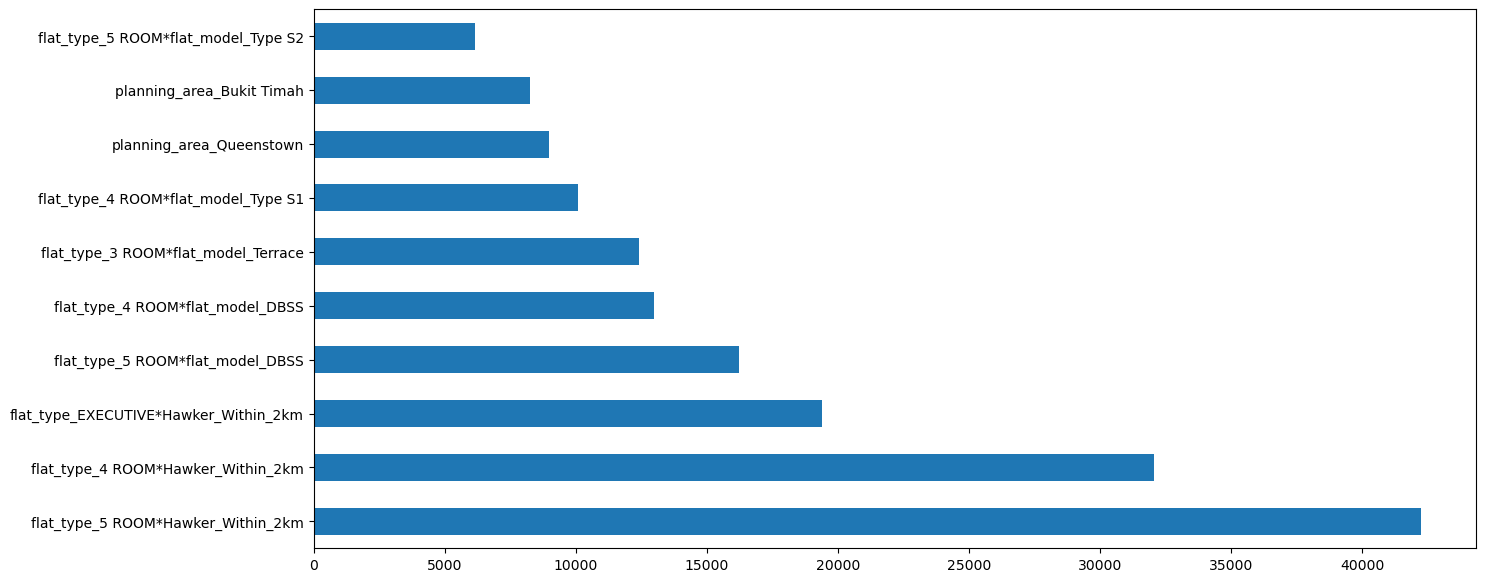

In [30]:
(pd.Series(lr.coef_, index = X.columns)
 .sort_values(ascending=False)[:10]
 .plot(kind = 'barh', figsize=(15,7)))
plt.show()

From the coefficients bar plots, we can see that we cannot directly intepret the coefficients because of the interaction values.

It does not make sense that 4 room flats cause prices to drop drastically while 4 room flats with centres within 2km cause prices to rise as well.

In [31]:
ridge.intercept_

448838.881639548

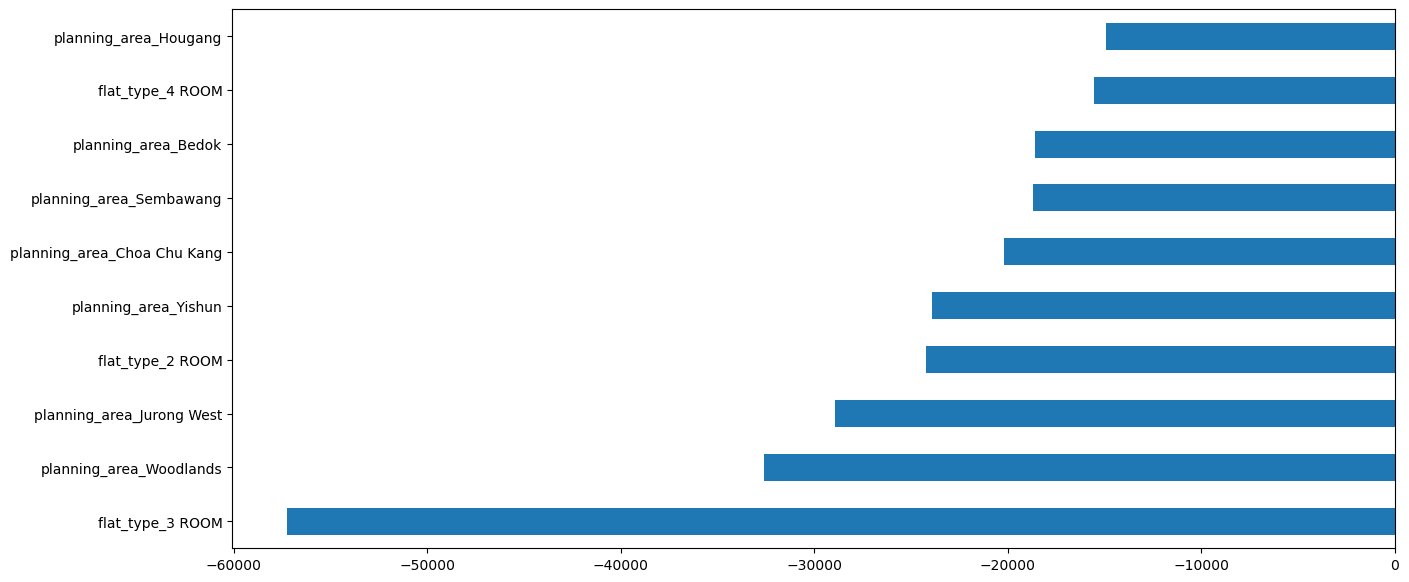

In [32]:
(pd.Series(ridge.coef_, index = X.columns)
 .sort_values(ascending=True)[:10]
 .plot(kind = 'barh', figsize=(15,7)))
plt.show()

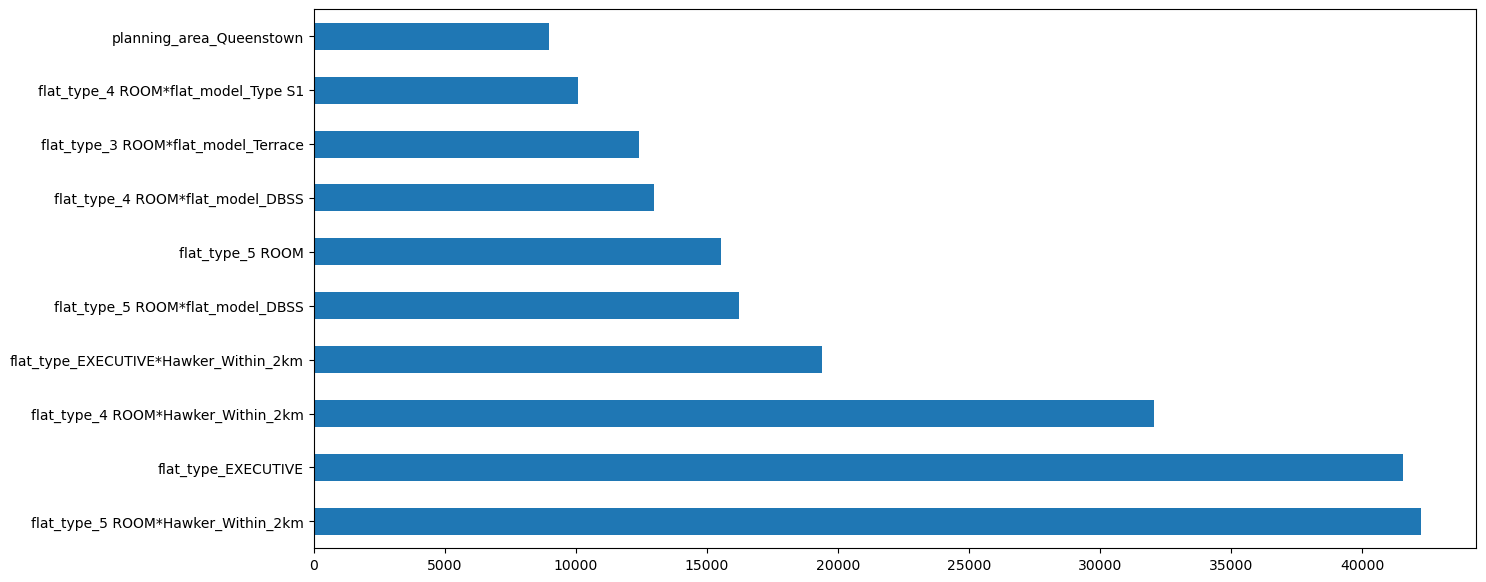

In [33]:
(pd.Series(ridge.coef_, index = X.columns)
 .sort_values(ascending=False)[:10]
 .plot(kind = 'barh', figsize=(15,7)))
plt.show()

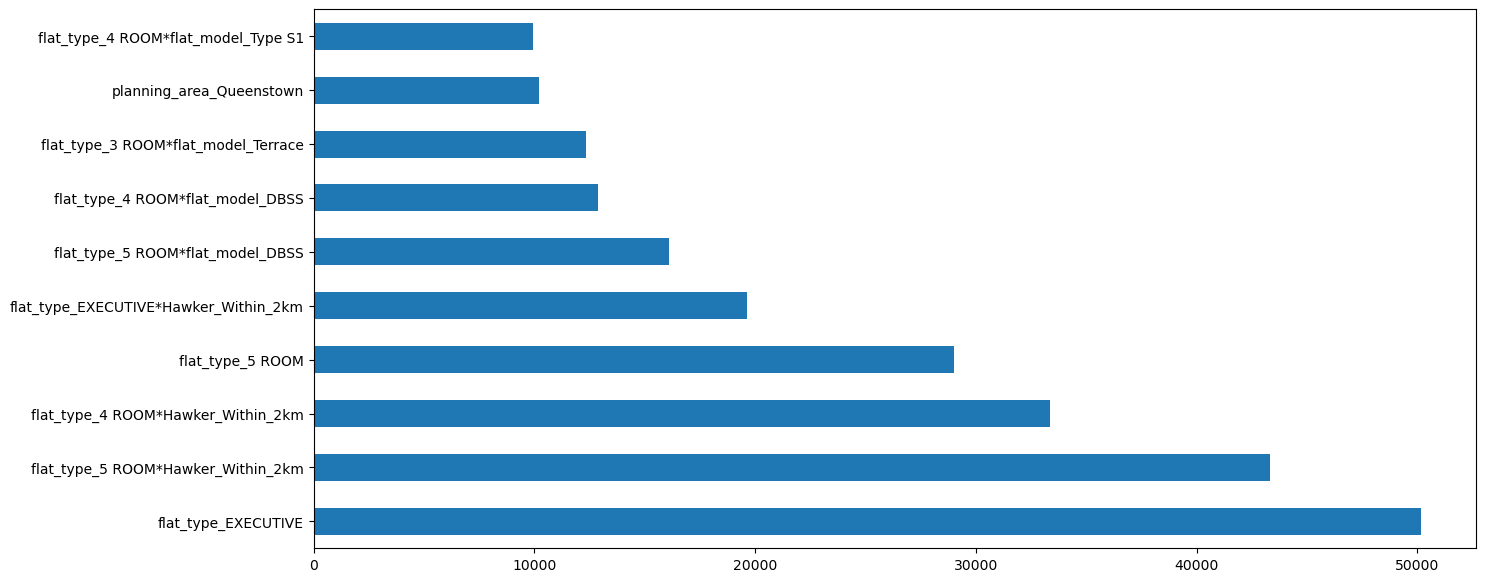

In [34]:
(pd.Series(lasso.coef_, index = X.columns)
 .sort_values(ascending=False)[:10]
 .plot(kind = 'barh', figsize=(15,7)))
plt.show()

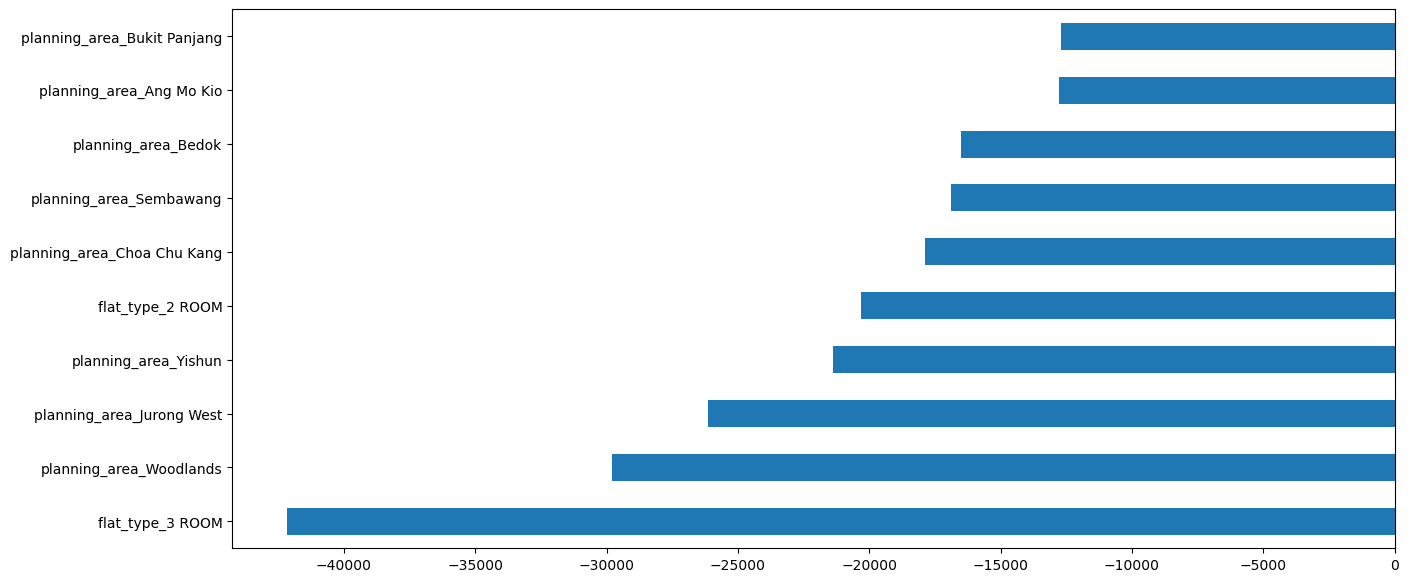

In [35]:
(pd.Series(lasso.coef_, index = X.columns)
 .sort_values(ascending=True)[:10]
 .plot(kind = 'barh', figsize=(15,7)))
plt.show()

In [36]:
pred = ridge.predict(X_test)

In [37]:
residual = y_test - pred

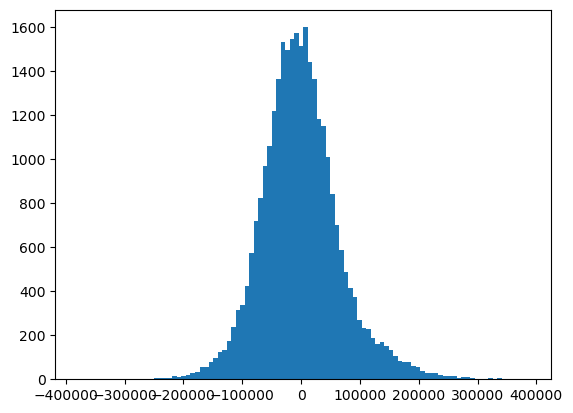

In [38]:
plt.hist(residual,bins=100)
plt.show()

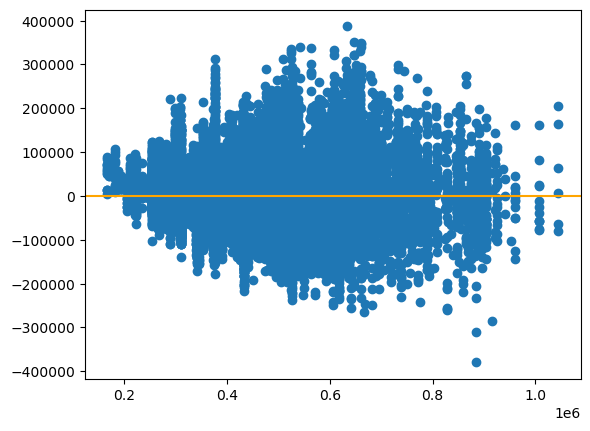

In [39]:
plt.scatter(x=pred, y=residual)
plt.axhline(0,color='orange')
plt.show()

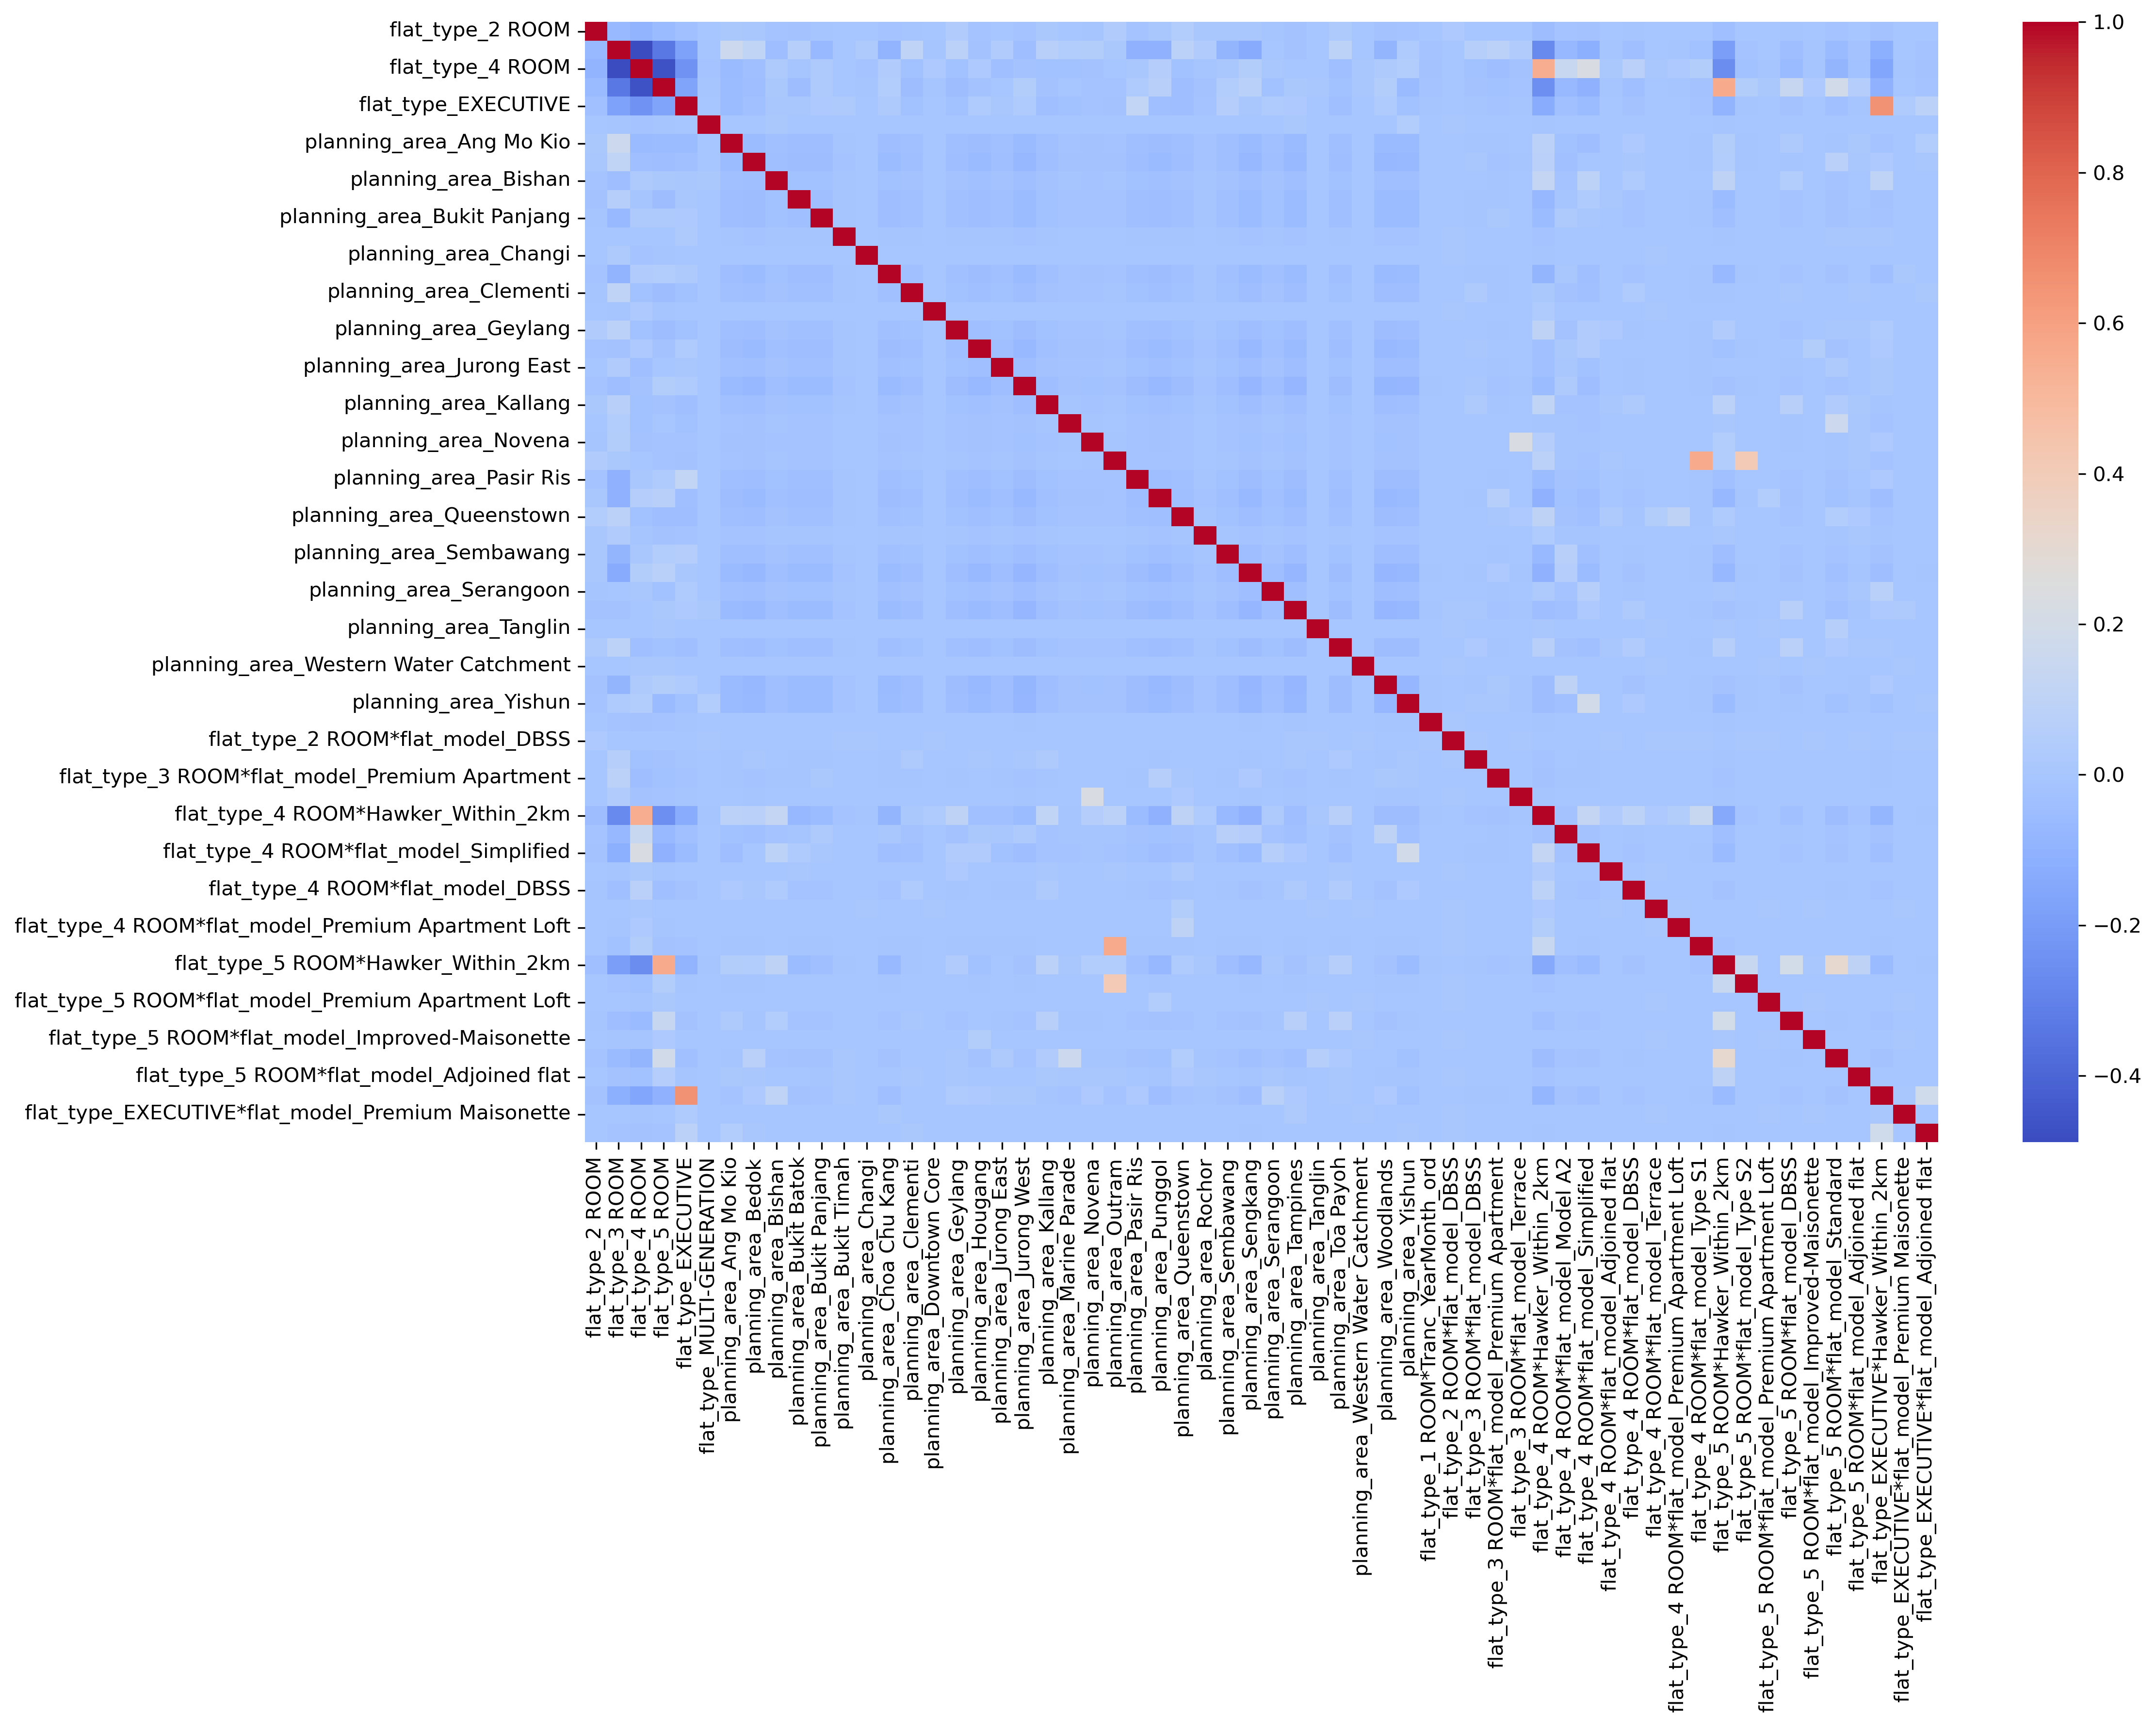

In [66]:
plt.figure(figsize=(15,10), dpi=300)
sns.heatmap(X.corr(), cmap='coolwarm');

# Second Kaggle Submission

In [41]:
df_validation = pd.read_csv(r'..\datasets\test.csv')

C:\Users\hammi\AppData\Local\Temp\ipykernel_1608\138062426.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_validation = pd.read_csv(r'..\datasets\test.csv')


In [42]:
df_validation.columns[41]

'postal'

Since we're not using postal, we can skip this step.

We'll first clean the data.

In [43]:
df_validation.isnull().sum().sort_values(ascending=False).head(10)

Hawker_Within_500m       10755
Mall_Within_500m         10292
Hawker_Within_1km         6729
Hawker_Within_2km         3254
Mall_Within_1km           2786
Mall_Within_2km            213
Mall_Nearest_Distance       84
mrt_name                     0
mrt_nearest_distance         0
hawker_market_stalls         0
dtype: int64

Since we are only using Hawker_Within_2km we will do a similar cleaning as seen in the EDA.

In [44]:
df_validation['Hawker_Nearest_Distance'].isnull().sum()

0

In [45]:
df_validation[['Hawker_Nearest_Distance', 'Hawker_Within_2km']].sort_values(by='Hawker_Nearest_Distance', ascending=False).head(10)

,Hawker_Nearest_Distance,Hawker_Within_2km
2504,4816.062542,NaN
15828,4776.690713,NaN
7539,4774.659106,NaN
4601,4767.540919,NaN
2968,4767.540919,NaN
1436,4762.878663,NaN
7217,4760.639080,NaN
2239,4760.639080,NaN
10624,4760.639080,NaN
2362,4760.639080,NaN


We will impute 0 for the null values.

In [46]:
df_validation['Hawker_Within_2km']=df_validation['Hawker_Within_2km'].fillna(0)

We have two features that we have to create, `Tranc_YearMonth` and `area_cost`.

In [47]:
df_validation['Tranc_YearMonth_ord']=pd.to_datetime(df_validation['Tranc_YearMonth']).map(lambda d: d.toordinal())

We will now create the `area_cost` feature in the validation set.

In [48]:
lookup = df[['flat_type','planning_area','area_cost']].value_counts().to_frame('count').sort_values(by='planning_area').reset_index()

In [49]:
lookup

,flat_type,planning_area,area_cost,count
0,5 ROOM,Ang Mo Kio,very expensive,891
1,4 ROOM,Ang Mo Kio,expensive,1821
2,EXECUTIVE,Ang Mo Kio,very expensive,88
3,2 ROOM,Ang Mo Kio,expensive,147
4,3 ROOM,Ang Mo Kio,expensive,3960
...,...,...,...,...
138,3 ROOM,Yishun,affordable,3158
139,EXECUTIVE,Yishun,affordable,510
140,2 ROOM,Yishun,affordable,68
141,4 ROOM,Yishun,cheap,4844


To replicate the `area_cost` feature, we'll need to merge the dataframes to match based on `flat_type` and `planning_area`

In [50]:
df_validation = pd.merge(df_validation, lookup, left_on = ['flat_type', 'planning_area'], right_on=['flat_type','planning_area'],how = 'inner')

In [51]:
df_validation[['flat_type','planning_area','area_cost']].value_counts().to_frame('counts').sort_values(by='planning_area')

,,,counts
flat_type,planning_area,area_cost,
4 ROOM,Ang Mo Kio,expensive,216
5 ROOM,Ang Mo Kio,very expensive,102
3 ROOM,Ang Mo Kio,expensive,483
EXECUTIVE,Ang Mo Kio,very expensive,5
2 ROOM,Ang Mo Kio,expensive,18
...,...,...,...
4 ROOM,Yishun,cheap,525
2 ROOM,Yishun,affordable,9
MULTI-GENERATION,Yishun,affordable,5


We have successfully added the `area_cost` to the validation set.

In [52]:
X = prep_data(df)
X_validation = prep_data(df_validation)

In [53]:
df['resale_price']*100_000

0         680000.0
1         665000.0
2         838000.0
3         550000.0
4         298000.0
            ...   
149800    625000.0
149801    455000.0
149802    733000.0
149803    338000.0
149804    765000.0
Name: resale_price, Length: 149805, dtype: float64

In [54]:
X.shape

(149805, 60)

In [55]:
X_validation.shape

(16737, 60)

In [56]:
lr = LinearRegression()

In [57]:
lr.fit(X, y)

LinearRegression()

In [58]:
lr.predict(X_validation)

array([325163.22846802, 401943.0617291 , 401943.0617291 , ...,
       914654.92956547, 750682.0608944 , 283256.43904867])

In [59]:
final_predicts = pd.DataFrame(data=[df_validation['id'],np.transpose(lr.predict(X_validation))], columns=['Id','Predicted'])

In [60]:
final_predicts = pd.DataFrame({'Id':df_validation['id'],'Predicted':lr.predict(X_validation)})

In [61]:
df_validation['id']

0        114982
1         30060
2         52407
3         99428
4          5470
          ...  
16732    185382
16733    182897
16734    184700
16735    164277
16736      3874
Name: id, Length: 16737, dtype: int64

In [63]:
final_predicts.to_csv(r'..\datasets\predictions_2.csv', index=False)